# Knowledge Graph Construction
##### Web Based Systems 2025, [FCSE](https://finki.ukim.mk/)

Here, we'll focus on extracting structured information from short text documents, specifically, stock news headlines, to construct a knowledge graph.

We will use a state-of-the-art Transformer model for triple extraction from unstructured text: [**REBEL** (Relation Extraction By End-to-end Language generation)](https://arxiv.org/abs/2306.09802). This model allows us to directly generate subject-predicate-object triples from raw text, enabling the knowledge graph creation process.

To further refine the graph, we will perform **entity resolution**, which identifies whether multiple records refer to the same real-world entity. For this, we will use the `sentence-transformers` library, which provides models capable of generating high-quality text embeddings in over 100 languages. By comparing these embeddings, using measures like cosine similarity, we can detect semantically similar entities and normalize the knowledge graph.


## Requirements

In [1]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from sentence_transformers import SentenceTransformer, util
import torch
import pandas as pd
from tqdm import tqdm
import networkx as nx
from networkx import connected_components
import matplotlib.pyplot as plt

## Triples Extraction Using REBEL

For our use case, we will use the **multilingual version of the REBEL model (mREBEL)**, available on the HuggingFace model hub [here](https://huggingface.co/Babelscape/mrebel-large). mREBEL can function either as a **standalone multilingual relation extraction system** or as a **pretrained model** that can be fine-tuned on multilingual relation extraction datasets.


We set the device to `cuda` if an NVIDIA GPU is available; otherwise, the model will run on the CPU.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

We will follow the instructions defined in the model card in order to use the model properly for relation-extraction.

The function ```extract_triplets_typed``` is provided by the creators of the model. It's a utility function that helps us parse the generated triples from the model.

In [3]:
def extract_triplets_typed(text):
    triplets = []
    relation = ''
    text = text.strip()
    current = 'x'
    subject, relation, object_, object_type, subject_type = '','','','',''

    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").replace("tp_XX", "").replace("__en__", "").split():
        if token == "<triplet>" or token == "<relation>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'head_type': subject_type, 'type': relation.strip(),'tail': object_.strip(), 'tail_type': object_type})
                relation = ''
            subject = ''
        elif token.startswith("<") and token.endswith(">"):
            if current == 't' or current == 'o':
                current = 's'
                if relation != '':
                    triplets.append({'head': subject.strip(), 'head_type': subject_type, 'type': relation.strip(),'tail': object_.strip(), 'tail_type': object_type})
                object_ = ''
                subject_type = token[1:-1]
            else:
                current = 'o'
                object_type = token[1:-1]
                relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '' and object_type != '' and subject_type != '':
        triplets.append({'head': subject.strip(), 'head_type': subject_type, 'type': relation.strip(),'tail': object_.strip(), 'tail_type': object_type})
    return triplets

We will use a beam search of 3, and generate 3 triplets per input text. We will set the maximum length of the generated sequence to be 256 tokens, and we will not penalize the model for generating lengthy sequences. This is done by setting the following parameters:

```json
{
    "max_length": 256,
    "length_penalty": 0,
    "num_beams": 3,
    "num_return_sequences": 3
}
```

In [4]:
gen_kwargs = {
  "max_length": 256,
  "length_penalty": 0,
  "num_beams": 3,
  "num_return_sequences": 3,
}

Next, we load the model and the tokenizer.

In [5]:
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/mrebel-large")

We set **English (`"en_XX"`)** as the source language. To use a different source language, simply replace the first token of the input with the desired language or choose any language supported by the model.

**Note:** For languages not included in mBART pretraining, such as Catalan (`"ca_XX"`) or Greek (`"el_EL"`), a small workaround is required:

```python
tokenizer._src_lang = "ca_XX"
tokenizer.cur_lang_code_id = tokenizer.convert_tokens_to_ids("ca_XX")
tokenizer.set_src_lang_special_tokens("ca_XX")
```


In [6]:
tokenizer = AutoTokenizer.from_pretrained("Babelscape/mrebel-large", src_lang="en_XX", tgt_lang="tp_XX")

We move the model to the device (CPU or GPU).

In [7]:
model.to(device)

MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): MBartScaledWordEmbedding(250071, 1024, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): MBartScaledWordEmbedding(250071, 1024, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x MBartEncoderLayer(
          (self_attn): MBartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True

In [8]:
def tokenize_and_extract_relations(batch):
  model_inputs = tokenizer(batch, max_length=256, padding=True, truncation=True, return_tensors="pt")

  generated_tokens = model.generate(
    model_inputs["input_ids"].to(model.device),
    attention_mask=model_inputs["attention_mask"].to(model.device),
    decoder_start_token_id = tokenizer.convert_tokens_to_ids("tp_XX"),
    **gen_kwargs,
  )

  decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

  result = []
  for idx, sentence in enumerate(decoded_preds):
    result.extend(extract_triplets_typed(sentence))
  return result

## Dataset

In [9]:
data = pd.read_csv("Stock_headlines.csv")

In [10]:
data.head()

,Unnamed: 0,Sentiment,Sentence
0,0,0,"According to Gran , the company has no plans t..."
1,1,1,"For the last quarter of 2010 , Componenta 's n..."
2,2,1,"In the third quarter of 2010 , net sales incre..."
3,3,1,Operating profit rose to EUR 13.1 mn from EUR ...
4,4,1,"Operating profit totalled EUR 21.1 mn , up fro..."


We will create a knowledge graph using the first 700 headlines in the dataset (because of execution time restrictions).

In [11]:
sentences = list(data["Sentence"].values)

In [12]:
sentences[:10]

['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ',
 "For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m ",
 'In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn ',
 'Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales ',
 'Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales ',
 'Finnish Talentum reports its operating profit increased to EUR 20.5 mn in 2005 from EUR 9.3 mn in 2004 , and net sales totaled EUR 103.3 mn , up from EUR 96.4 mn ',
 "Clothing retail chain Sepp+ñl+ñ 's sales increased by 8 % to EUR 155.2 mn , and operating profit rose to EUR 31.1 mn from EUR 17.1 mn in 2004

In [13]:
kg = []

In [14]:
batch_size = 16

In [15]:
for i in tqdm(range(0, 700, batch_size)):
  kg.extend(tokenize_and_extract_relations(sentences[i:i+batch_size]))

100%|██████████| 44/44 [00:47<00:00,  1.09s/it]


The results include the columns `head`, `head_type`, `type`, `tail`, and `tail_type`. We will convert these results into a dictionary and remove duplicate triples based on `head`, `type`, and `tail`. This is necessary because the model may assign multiple types to the same head (for example, both `concept` and `location`).

In [16]:
kg_relations = pd.DataFrame(kg)

In [17]:
kg_relations = kg_relations.dropna()

In [18]:
kg_relations = kg_relations.drop_duplicates(subset=["head", "type", "tail"], keep="first")

In [19]:
kg_relations

,head,head_type,type,tail,tail_type
0,Gran,org,country,Russia,loc
1,Russia,loc,item operated,Gran,org
2,Russia,loc,subsidiary,Gran,org
3,2010,time,point in time,2010,date
6,third quarter of 2010,time,point in time,2010,date
...,...,...,...,...,...
2330,Sanoma Learning & Literature,org,country,Finnish,loc
2335,Nobel Biocare,org,inception,2007,date
2336,passenger car,concept,subclass of,commercial vehicle,concept
2337,passenger cars,concept,subclass of,commercial vehicle,concept


Save the dataset

In [20]:
kg_relations.to_csv("kg_stock_headlines.csv", index=False)

## Entity Resolution

We will use a lightweight model from the `sentence-transformers` library to generate embeddings for each head and tail entity. These embeddings capture the semantic meaning of the text, allowing us to compare entities based on their content.

Using a brute-force approach, we compute the **cosine similarity** between all entity embeddings. Entities with a similarity score greater than **0.95** are considered to represent the same concept. This process is implemented in the function `resolve_entities_by_text_embeddings`.


In [21]:
def resolve_entities_by_text_embeddings(entities, embeddings):
  entity_mapping = {}
  for i in range(len(entities)):
    e1 = entities[i]
    for j in range(i + 1, len(entities)):
      e2 = entities[j]

      if e1 == e2:
        continue

      similarity = util.cos_sim(embeddings[i], embeddings[j])

      if similarity > 0.95:
        entity_mapping[entities[j]] = entities[i]
        entities[j] = entities[i]
        embeddings[j] = embeddings[i]

  return entity_mapping

In [22]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [23]:
embedding_model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [24]:
entities = list(set(kg_relations["head"].values + kg_relations["tail"].values))  # We convert to `set` and then to `list` to remove any duplicates.

In [25]:
len(entities)

1309

In [26]:
entity_embeddings = embedding_model.encode(entities)

Next, we will perform entity resolution on the head and tail texts (subjects and objects in the relation).

In [27]:
entities_resolution_dict = resolve_entities_by_text_embeddings(entities, entity_embeddings)

In [28]:
entities_resolution_dict

{'publication paperpaper': 'publication paperspaper',
 'EUR17mEUR21m': 'EUR21mEUR17m',
 'filtersfilter sales': 'filterfilter sales',
 'cocktail glassesstainless steel': 'cocktail glassstainless steel',
 'Tikkurila Powder Coatingspaint plants': 'Tikkurila Powder Coatingspaint plant',
 'KauppalehtiMarketplace': 'KauppalehtiMarketplaces',
 '$euro': 'euro$',
 'branch librarieslibrary system': 'branch librarieslibrary',
 "Satama and Trainers ' Housebrands": "Satama and Trainers ' Housebrand",
 '20072007': '20082007',
 '20082008': '20082007',
 'EUR 0.27EUR 0.8': 'EUR 0.27EUR 0.6',
 'EUR 0.27EUR 0.186': 'EUR 0.27EUR 0.6',
 'EUREUR': 'eureur',
 'earnings per shareearnings per': 'earnings per shareearnings',
 'FinnishEURO': 'Finnisheuro',
 'The agreementagreement': 'agreementagreement',
 'Baswareshares': 'BasWareshares',
 'wireless handsetwireless carrier': 'wireless handsetwireless carriers',
 'historic analysismarket': 'historic analysismarkets',
 'SwedenFinland': 'SwedishFinland',
 'correspo

Here, we'll replace the name of the entities using the mapping dictionary.

In [29]:
kg_relations = kg_relations.replace({"head": entities_resolution_dict, "tail": entities_resolution_dict})

In [30]:
len(kg_relations)

1525

We are going to drop duplicate triples since now they may appear again after the entity resolution step.

In [31]:
kg_relations = kg_relations.drop_duplicates(subset=['head', 'type', 'tail'], keep='first')

In [32]:
kg_relations = kg_relations.dropna()

In [33]:
len(kg_relations)

1525

We save the normalized triples.

In [34]:
kg_relations.to_csv("kg_stock_headlines_normalized.csv", index=False)

We are going to create a NetworkX graph to visualize the extracted information.

In [35]:
G = nx.Graph()
for _, row in kg_relations.iterrows():
  G.add_edge(row["head"], row["tail"], label=row["type"])

In [36]:
components = [c for c in connected_components(G)]

In [37]:
len(components)

236

We create a subgraph using the largest connected component.

In [38]:
graph_to_draw = G.subgraph(components[0])

In [39]:
graph_to_draw

In [40]:
len(components[0])

631

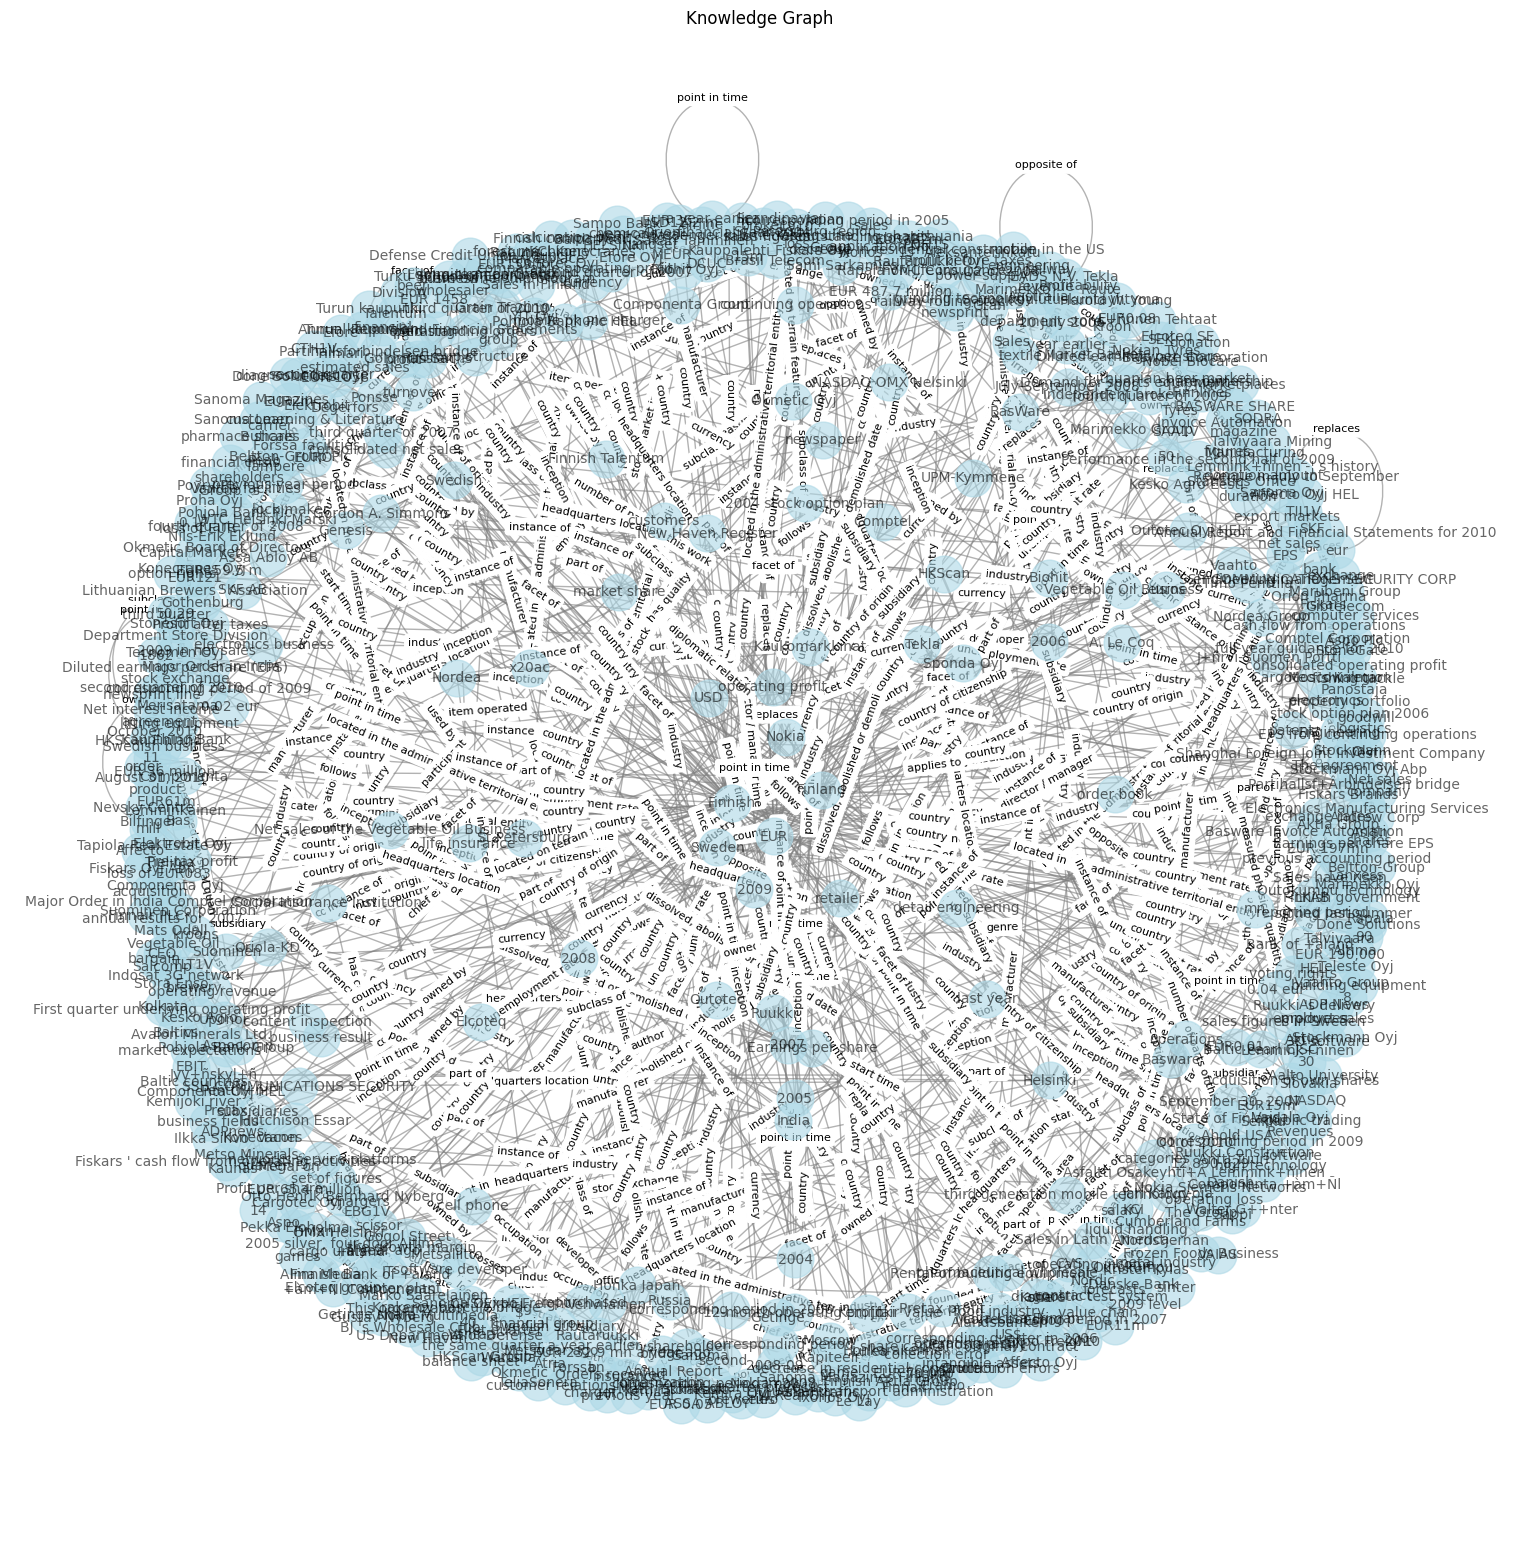

In [41]:
pos = nx.spring_layout(graph_to_draw, seed=42, k=0.9)
labels = nx.get_edge_attributes(graph_to_draw, 'label')
plt.figure(figsize=(15, 15))
nx.draw(graph_to_draw, pos, with_labels=True, font_size=10, node_size=700, node_color='lightblue', edge_color='gray', alpha=0.6)
nx.draw_networkx_edge_labels(graph_to_draw, pos, edge_labels=labels, font_size=8, label_pos=0.3, verticalalignment='baseline')
plt.title('Knowledge Graph')
plt.show()

In [42]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f'Number of nodes: {num_nodes}')
print(f'Number of edges: {num_edges}')
print(f'Ratio edges to nodes: {round(num_edges / num_nodes, 2)}')

Number of nodes: 1337
Number of edges: 1221
Ratio edges to nodes: 0.91


# Entity and Relation Types

Let's take a look at the types of entities and relations that we have extracted from the headlines.

In [43]:
kg_relations["head_type"].unique()

array(['org', 'loc', 'time', 'concept', 'eve', 'media', 'per', 'misc', ''],
      dtype=object)

In [44]:
kg_relations["tail_type"].unique()

array(['loc', 'org', 'date', 'concept', 'eve', 'media', 'misc', 'per',
       'num', 'time'], dtype=object)

In [45]:
kg_relations["type"].unique()

array(['country', 'item operated', 'subsidiary', 'point in time',
       'inception', 'manufacturer', 'industry', 'subclass of', 'facet of',
       'opposite of', 'instance of', 'owned by', 'follows', 'currency',
       'replaces', 'part of', 'measured physical quantity', 'start time',
       'publisher', 'author', 'educated at', 'country of citizenship',
       'country of origin', 'headquarters location', 'brand',
       'diplomatic relation', 'studies', 'end time',
       'chief executive officer', 'employer', 'director / manager',
       'unemployment rate', 'elevation above sea level',
       'number of parts of this work', 'duration', 'developer',
       'stock exchange', 'occupation', 'position held', 'model item',
       'operating area', 'business division', 'stock market index',
       'location', 'located in the administrative territorial entity',
       'founded by', 'use', 'residence', 'chairperson',
       'dissolved, abolished or demolished date',
       'date of officia

# Neo4j Graph Database

A graph database stores nodes and relationships instead of tables, or documents.

Your data is stored without restricting it to a pre-defined model, allowing a very flexible way of thinking about and using it.

Neo4j is an open-source, NoSQL, native graph database that provides an ACID-compliant transactional backend for your applications that has been publicly available since 2007.

Neo4j is offered as a managed service via AuraDB. But you can also run Neo4j yourself with either Community Edition or Enterprise Edition.

We are going to create a free, managed instance of AuraDB to store our graph.

In [46]:
from neo4j import GraphDatabase

In [47]:
URL = "neo4j+s://<db_id>.databases.neo4j.io"
username = "<username>"
password = "<password>"
AUTH = (username, password)

In [48]:
def insert_data_into_neo4j(df, driver):
  with driver.session() as session:
    for index, row in df.iterrows():
      query = f"""
      MERGE (h:{row['head_type']} {{name: $head}})
      MERGE (t:{row['tail_type']} {{name: $tail}})
      MERGE (h)-[:{row['type'].replace(' ', '_')}]->(t)
      """

      try:
        session.run(query, head=row["head"], tail=row["tail"])
      except Exception:
        continue

In [ ]:
with GraphDatabase.driver(URL, auth=AUTH) as driver:
  driver.verify_connectivity() 
  insert_data_into_neo4j(kg_relations, driver)

Here, we can see the subgraph for the relation `diplomatic relation`.

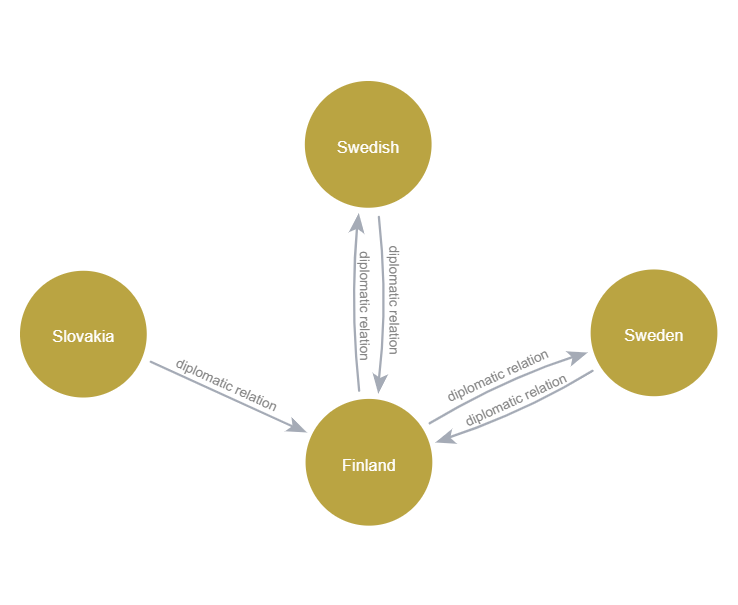**